# Skip-gram

## Setup

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# hyperparameters
threshold = 10
context_size = 5 # how many words on each side
n_embd = 96
batch_size = 256
learning_rate = 1e-4
max_iters = 50000
eval_interval = 500
eval_iters = 100
# device = 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

butchering_length = context_size # how many words to keep around my special topics

In [5]:
# read another dataset
# http://mattmahoney.net/dc/textdata.html

with open('text8', 'r') as f:
    text = f.read()

print(f'{len(text)=}')
print(f'{len(text.split())=}')
print(f'alphabet = "{"".join(sorted(set(text)))}"')

vocab = list(set(text.split()))
print(f'{vocab[:10]=}')
print(f'{len(vocab)=}')

len(text)=100000000
len(text.split())=17005207
alphabet = " abcdefghijklmnopqrstuvwxyz"
vocab[:10]=['chairmanships', 'fugees', 'philodemus', 'hessdalen', 'akatsuki', 'delimitative', 'overthrows', 'scheiner', 'dabbled', 'wethers']
len(vocab)=253854


In [6]:
# how crappy is my dataset ? :(
from collections import Counter

# looking at the sorted vocab give me very low confidence in the dataset quality
print(f'{sorted(vocab)[:100]=}')
cs = Counter(text.split())
print(f'{cs.most_common(100)=}')
print(f'{cs["aaaaaacceglllnorst"]=}')

# lots of words are only mentioned once
ccs = Counter(cs.values())
print(ccs.most_common(10))

# on the plus side 'queen' and 'king' seem well represented
print(f'{cs["king"]=} {cs["queen"]=}')


sorted(vocab)[:100]=['a', 'aa', 'aaa', 'aaaa', 'aaaaaacceglllnorst', 'aaaaaaccegllnorrst', 'aaaaaah', 'aaaaaalmrsstt', 'aaaaaannrstyy', 'aaaaabbcdrr', 'aaaaargh', 'aaaargh', 'aaaassembly', 'aaab', 'aaabbbccc', 'aaahh', 'aaai', 'aaake', 'aaan', 'aaargh', 'aaas', 'aaate', 'aab', 'aababb', 'aabach', 'aabba', 'aabbcc', 'aabbirem', 'aabebwuvev', 'aabehlpt', 'aabmup', 'aabre', 'aabybro', 'aac', 'aaca', 'aacca', 'aaccording', 'aachen', 'aachener', 'aachtopf', 'aaci', 'aacis', 'aacisuan', 'aacplus', 'aacr', 'aacs', 'aacvd', 'aad', 'aadgad', 'aadl', 'aadlik', 'aadnani', 'aadvantage', 'aadyam', 'aaemu', 'aaf', 'aafc', 'aafjes', 'aafk', 'aafp', 'aag', 'aagaard', 'aagama', 'aagard', 'aage', 'aagesen', 'aagsin', 'aah', 'aahaaram', 'aahc', 'aahe', 'aahl', 'aahz', 'aai', 'aaib', 'aaiieee', 'aaimmah', 'aairpass', 'aaiun', 'aaiyangar', 'aaj', 'aajker', 'aak', 'aakirkeby', 'aakjaer', 'aakkram', 'aal', 'aalberg', 'aalborg', 'aalborghus', 'aalborgt', 'aalcc', 'aale', 'aalen', 'aalens', 'aalesund', 'aalesu

In [7]:
# let's butcher the dataset ¯\_(ツ)_/¯
# remove all the words that are only mentioned bellow a threshold
butchered_vocab = [w for w, c in cs.items() if c >= threshold]
butchered_vocab_s = set(butchered_vocab)
butchered_text = [w for w in text.split() if w in butchered_vocab_s]

print(f'{len(butchered_vocab)=}')
print(f'{len(butchered_text)=}')

len(butchered_vocab)=47134
len(butchered_text)=16561031


In [8]:
# still doesn't work, second round of butchering ¯\_(ツ)_/¯
# new idea, keep the context around the words I care about learning, and trash the rest of the dataset

words_i_want_to_learn = [
    'red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink',
    'king', 'queen', 'prince', 'princess', 'duke', 'lord', 'lady', 'sir', 'man', 'woman', 'male', 'female',
    'fruit', 'apple', 'orange', 'banana',
    'dog', 'cat', 'horse', 'cow', 'chicken', 'bird', 'fish', 'sheep', 'elephant',
    #'paris', 'london', 'madrid', 'beijing', 'tokyo', 'moscow', 'berlin', 'rome', 'washington', 'brussels', 'jerusalem', 'amsterdam', 'vienna', 'geneva' 
]

# words I wanted but they are kinda rare in my dataset:
# ['lemon', 'lime', 'watermelon', 'clementine', 'tangerine', 'madam', 'mango', 'strawberry', 'pear', 'coconut', 'kiwi', 'duchess', 'grape',]

for ct, w in sorted([(cs[w], w) for w in words_i_want_to_learn]):
    print(f'{w=}: {ct=}')

topics_whitelist = set(words_i_want_to_learn)
butchered_sentences2 = []
for i in range(butchering_length, len(butchered_text) - butchering_length):
    w = butchered_text[i]
    if w in topics_whitelist:
        butchered_sentences2.append(butchered_text[i - butchering_length: i + butchering_length + 1])

butchered_text2 = [w for s in butchered_sentences2 for w in s]
butchered_vocab2 = sorted(set(butchered_text2))

print(butchered_sentences2[:3])
print(f'{len(butchered_text)=} {len(butchered_text2)=}')
print(f'{len(butchered_vocab)=} {len(butchered_vocab2)=}')


w='banana': ct=111
w='chicken': ct=241
w='pink': ct=249
w='purple': ct=267
w='sheep': ct=305
w='elephant': ct=314
w='cow': ct=332
w='princess': ct=504
w='bird': ct=596
w='fruit': ct=601
w='orange': ct=607
w='orange': ct=607
w='cat': ct=692
w='yellow': ct=733
w='lady': ct=812
w='dog': ct=958
w='fish': ct=1174
w='horse': ct=1180
w='apple': ct=1465
w='sir': ct=1488
w='duke': ct=1611
w='prince': ct=1687
w='woman': ct=1753
w='queen': ct=1940
w='green': ct=2074
w='blue': ct=2223
w='lord': ct=2231
w='male': ct=2615
w='female': ct=2797
w='red': ct=3755
w='man': ct=5778
w='king': ct=7456
[['greek', 'without', 'archons', 'ruler', 'chief', 'king', 'anarchism', 'as', 'a', 'political', 'philosophy'], ['they', 'held', 'that', 'the', 'good', 'man', 'will', 'be', 'guided', 'at', 'every'], ['that', 'warren', 'was', 'the', 'first', 'man', 'to', 'expound', 'and', 'formulate', 'the']]
len(butchered_text)=16561031 len(butchered_text2)=534039
len(butchered_vocab)=47134 len(butchered_vocab2)=25518


In [9]:
# encode/decode helpers
vocab_size = len(butchered_vocab2)
stoi = {w: i for i, w in enumerate(butchered_vocab2)}
itos = {i: w for w, i in stoi.items()}

def encode(ws):
    return torch.tensor([stoi[w] for w in ws], dtype=torch.long)

def decode(t):
    t = t.tolist() if isinstance(t, torch.Tensor) else t
    t = [t] if isinstance(t, int) else t
    return ' '.join([itos[i] for i in t])

# for xs in ['i for one welcome our new robot overlords', 'the chicken cross the road']:
for xs in ['kings queens and fruits', 'white chicken black horse or brown cow']:
    print(f'{encode(xs.split())=}')
    print(f'{decode(encode(xs.split()))=}')

encode(xs.split())=tensor([12895, 18713,   975,  9438])
decode(encode(xs.split()))='kings queens and fruits'
encode(xs.split())=tensor([24989,  4145,  2648, 11175, 16512,  3187,  5497])
decode(encode(xs.split()))='white chicken black horse or brown cow'


In [10]:
# shape the data for training
# using the skip-gram method
def chunk(ws):
    x, y = [], []
    # miss a few words at the beginning and end of the text, w/e
    for i in range(context_size, len(ws) - context_size):
        x.append(ws[i])
        # TODO: here a possible optimization would be to probabilistically discard some of the most common words
        # the paper suggest proba to keep the word as:
        # $P(w_i) = ({\sqrt {z(w_i) \over 0.001} + 1}) . {0.001 \over z(w_i)}$
        # z(w_i) being the frequency of the word in the corpus
        y.append(torch.cat((ws[i - context_size: i], ws[i + 1: i + 1 + context_size])))
    return torch.tensor(x).view(-1, 1), torch.stack(y)

X, Y = chunk(encode(butchered_text2))
print(X.shape, Y.shape)

for i in range(3):
    print(X[i], Y[i])
    print(f'{decode(X[i])=} {decode(Y[i])=}')

torch.Size([534029, 1]) torch.Size([534029, 10])
tensor([12889]) tensor([10181, 25152,  1355, 20073,  4151,   952,  1506,     0, 17792, 17428])
decode(X[i])='king' decode(Y[i])='greek without archons ruler chief anarchism as a political philosophy'
tensor([952]) tensor([25152,  1355, 20073,  4151, 12889,  1506,     0, 17792, 17428, 23097])
decode(X[i])='anarchism' decode(Y[i])='without archons ruler chief king as a political philosophy they'
tensor([1506]) tensor([ 1355, 20073,  4151, 12889,   952,     0, 17792, 17428, 23097, 10757])
decode(X[i])='as' decode(Y[i])='archons ruler chief king anarchism a political philosophy they held'


In [11]:
def get_batch():
    ix = torch.randint(len(X), (batch_size,))
    x, y = X[ix], Y[ix]
    x, y = x.to(device), y.to(device)
    return x, y

xb, yb = get_batch()
print(xb[:2])
print(yb[:2])
print(f'{decode(xb[0])} -> {decode(yb[0])}')
print(f'{decode(xb[1])} -> {decode(yb[1])}')

tensor([[  975],
        [11389]], device='cuda:0')
tensor([[ 9166,   975, 25143,  2921,  9258,  1946, 11175, 21000, 23282, 11729],
        [23153, 23807, 25480, 12889, 17364, 16341, 17904,  5851, 20804, 16441]],
       device='cuda:0')
and -> for and with both forward backward horse shoes to indicate
i -> three two zero king peter of portugal d seven one


In [12]:
@torch.no_grad()
def estimate_loss():
    model.eval()
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
        x, y = get_batch()
        logits, loss = model(x, y)
        losses[k] = loss.item()
    out = losses.mean()
    model.train()
    return out

## Skip-gram model
given a word guess the (#context_size) words surrounding it.
e.g. "I for one welcome our robot overlords"

welcome -> for, one, our, robot


In [13]:
torch.manual_seed(0xdeadbeef) # for reproducibility

class LM(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.head = nn.Linear(n_embd, vocab_size)
        
    def forward(self, idx, targets=None):
        B, T = idx.shape
        # print(f'{idx.shape=} {targets.shape=}')
        tok_emb = self.token_embedding_table(idx) # (B, T, n_embd)
        # x = self.layers(tok_emb)
        logits = self.head(tok_emb) # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:
            # juggle with tensor shapes to match pytorch's cross_entropy
            # print(f'before: {logits.shape=} {targets.shape=}')
            # B, T, C = logits.shape
            # logits = logits.view(B * T, C)
            # targets = targets.view(B * T)
            # print(f'after:  {logits.shape=} {targets.shape=}')
            # loss = F.cross_entropy(logits, targets)

            # TODO: I give up on the clean solution for now, using an expected logits instead of ids
            # make expected a one-hot encoding
            logits = logits.view(-1, vocab_size)
            targets_logits = torch.zeros_like(logits)
            rows = torch.arange(targets.shape[0]).view(-1, 1)

            # print(f'{targets_logits.shape=} {rows.shape=} {targets.shape=}')
            targets_logits[rows, targets] = 1
            loss = F.binary_cross_entropy_with_logits(logits, targets_logits)
        return logits, loss
    
    # def generate(self, idx, max_new_tokens):
    #     for _ in range(max_new_tokens):
    #         # crop the context to the last block_size tokens
    #         idx_cond = idx[:, -block_size:]
    #         logits, loss = self(idx_cond)
    #         logits = logits[:, -1, :]
    #         probs = F.softmax(logits, dim=-1)
    #         idx_next = torch.multinomial(probs, num_samples=1)
    #         idx = torch.cat((idx, idx_next), dim=1)
    #     return idx
    
model = LM()
m = model.to(device)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss.item())
print(logits[0])

torch.Size([256, 25518])
0.7346323728561401
tensor([ 0.3184, -0.2789, -0.3453,  ...,  0.0501,  0.3762, -0.6509],
       device='cuda:0', grad_fn=<SelectBackward0>)


In [14]:
# Clear my head
mini_batch_size = 3
mini_embedding_size = 8
mini_surroundings = 4

logits = torch.ones((mini_batch_size, mini_embedding_size))
expected = torch.tensor([(0, 1, 3, 7), (0, 2, 4, 6), (4, 5, 6, 7)], dtype=torch.long)
# make expected a one-hot encoding
expected_logits = torch.zeros_like(logits)
rows = torch.arange(mini_batch_size).view(-1, 1)
expected_logits[rows, expected] = 1

expected_logits

tensor([[1., 1., 0., 1., 0., 0., 0., 1.],
        [1., 0., 1., 0., 1., 0., 1., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1.]])

In [15]:
# create a pytorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [16]:
# train
for iter in range(max_iters):
    if iter % eval_interval == 0:
        loss = estimate_loss()
        print(f'step {iter}: train loss {loss:.4f}')

    xb, yb = get_batch()
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 0.7340
step 500: train loss 0.5749
step 1000: train loss 0.4518
step 1500: train loss 0.3622
step 2000: train loss 0.3108
step 2500: train loss 0.2731
step 3000: train loss 0.2405
step 3500: train loss 0.2190
step 4000: train loss 0.1982
step 4500: train loss 0.1794
step 5000: train loss 0.1674
step 5500: train loss 0.1562
step 6000: train loss 0.1406
step 6500: train loss 0.1369
step 7000: train loss 0.1225
step 7500: train loss 0.1144
step 8000: train loss 0.1071
step 8500: train loss 0.0999
step 9000: train loss 0.0932
step 9500: train loss 0.0870
step 10000: train loss 0.0808
step 10500: train loss 0.0747
step 11000: train loss 0.0721
step 11500: train loss 0.0663
step 12000: train loss 0.0628
step 12500: train loss 0.0594
step 13000: train loss 0.0553
step 13500: train loss 0.0522
step 14000: train loss 0.0486
step 14500: train loss 0.0479
step 15000: train loss 0.0435
step 15500: train loss 0.0415
step 16000: train loss 0.0378
step 16500: train loss 0.0360
step

In [17]:
# backup to disk
# torch.save(model.state_dict(), 'skip-gram-colors.pt')

## can we use embeddings?

In [18]:
# Euclidean distance
def euclidean_dist(a, b):
    return torch.sqrt(torch.sum((a - b) ** 2))

# Cosine distance
def cosine_dist(a, b):
    # return 1 - (a @ b.T) / (torch.sqrt(torch.sum(a**2)) * torch.sqrt(torch.sum(b**2)))
    return 1 - torch.nn.functional.cosine_similarity(a, b, dim=0)

In [19]:
def get_embedding(word, m=m):
    return m.token_embedding_table(torch.tensor(stoi[word], dtype=torch.long, device=device))

king = get_embedding('king')
queen = get_embedding('queen')

print(king.shape)

print(f'{euclidean_dist(king, queen)=}')
print(f'{cosine_dist(king, queen)=}')

torch.Size([96])
euclidean_dist(king, queen)=tensor(16.1675, device='cuda:0', grad_fn=<SqrtBackward0>)
cosine_dist(king, queen)=tensor(0.8709, device='cuda:0', grad_fn=<RsubBackward1>)


In [20]:
soap = get_embedding('soap')

print(f'{euclidean_dist(king, soap)=}')
print(f'{cosine_dist(king, soap)=}')

euclidean_dist(king, soap)=tensor(15.9545, device='cuda:0', grad_fn=<SqrtBackward0>)
cosine_dist(king, soap)=tensor(1.0272, device='cuda:0', grad_fn=<RsubBackward1>)


In [21]:
# cross relations

import itertools
words = ['king', 'queen', 'prince', 'princess', 'man', 'woman', 'lettuce', 'green']
# words = ['flower', 'bee', 'dog', 'bone']
# words = ['yolk', 'egg', 'chicken', 'computer']
# words = ['sun', 'warm', 'snow', 'cold']
pairs = []
for a, b in itertools.combinations(words, 2):
    emb_a = get_embedding(a)
    emb_b = get_embedding(b)
    pairs.append((cosine_dist(emb_a, emb_b), a, b))

for d, a, b in sorted(pairs):
    print(f'{d:.4f} {a} {b}')

0.7027 king prince
0.7160 king man
0.7169 man woman
0.7620 queen man
0.7801 prince man
0.7908 princess green
0.8057 prince princess
0.8133 woman lettuce
0.8163 prince woman
0.8267 queen princess
0.8368 king woman
0.8507 princess man
0.8530 princess woman
0.8533 queen prince
0.8588 king lettuce
0.8589 queen woman
0.8621 woman green
0.8641 king princess
0.8680 prince green
0.8709 king queen
0.8719 queen green
0.8720 queen lettuce
0.8826 prince lettuce
0.9015 man green
0.9157 princess lettuce
0.9616 man lettuce
0.9851 king green
1.0808 lettuce green


In [22]:
lw = list(butchered_vocab_s)
lw[:10]

['strictest',
 'cereal',
 'overthrows',
 'quadruple',
 'dabbled',
 'triads',
 'becker',
 'dignities',
 'idealists',
 'mri']

In [23]:
# Words to choose from:
' '.join(words_i_want_to_learn)

'red green blue yellow orange purple pink king queen prince princess duke lord lady sir man woman male female fruit apple orange banana dog cat horse cow chicken bird fish sheep elephant'

In [51]:
# compare trained and untrained model
# <???> why is 'cow' so popular ?
word = 'pink'
# word = 'blue'
# word = 'yellow'
# word = 'prince'
# word = 'king'
# word = 'female'

untrained_model = LM()
um = untrained_model.to(device)

for mm, label in [(m, 'trained'), (untrained_model, 'untrained')]:
    print(f'--- {label} ---')
    emb_word = get_embedding(word, m=mm)
    matches = []
    # for w in lw[:]:
    for w in words_i_want_to_learn:
        if cs[w] < 100:
            continue
        emb_w = get_embedding(w, m=mm)
        d = cosine_dist(emb_word, emb_w)
        matches.append((d, w))

    for d, w in sorted(matches)[:10]:
        print(f'{d:.4f} {w}')


--- trained ---
0.0000 prince
0.7027 king
0.7509 duke
0.7516 male
0.7531 sir
0.7801 man
0.7917 sheep
0.8057 princess
0.8163 woman
0.8208 purple
--- untrained ---
0.0000 prince
0.7644 red
0.8549 green
0.8784 fruit
0.8892 duke
0.9167 blue
0.9222 bird
0.9361 sir
0.9391 male
0.9570 chicken


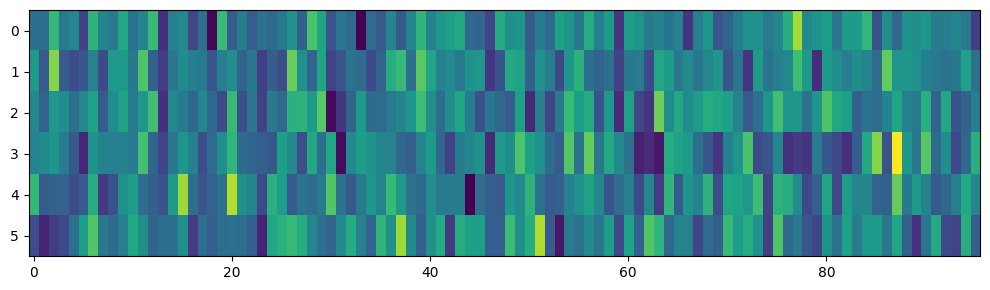

In [58]:
# visualize the embeddings
words = ['pink', 'blue', 'yellow', 'king', 'prince', 'duke']
embedding_matrix = torch.stack([get_embedding(w).cpu().detach() for w in words])

plt.figure(figsize=(10, 3))
plt.imshow(embedding_matrix, cmap='viridis', aspect='auto')
plt.tight_layout()
plt.show()

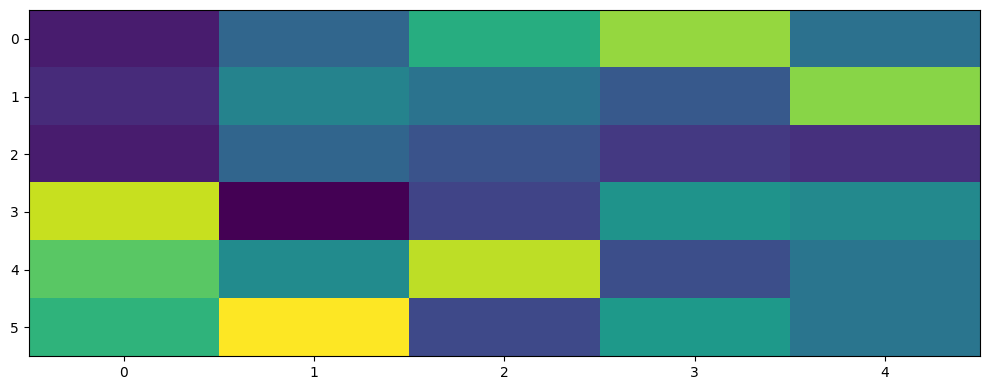

In [63]:
# visualize the embeddings with PCA
words = ['pink', 'blue', 'yellow', 'king', 'prince', 'duke']
embedding_matrix = torch.stack([get_embedding(w).cpu().detach() for w in words])

pca = PCA(n_components=len(words) - 1)
principal_components = pca.fit_transform(embedding_matrix)

plt.figure(figsize=(10, 4))
plt.imshow(principal_components, cmap='viridis', aspect='auto')
plt.tight_layout()
plt.show()

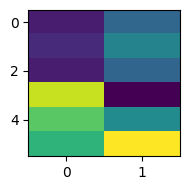

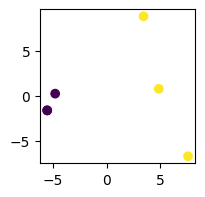

In [70]:
words = ['pink', 'blue', 'yellow', 'king', 'prince', 'duke']
embedding_matrix = torch.stack([get_embedding(w).cpu().detach() for w in words])
colors = torch.tensor([0, 0, 0, 1, 1, 1])

pca = PCA(n_components=2)
principal_components = pca.fit_transform(embedding_matrix)

# we lose a lot of information by projecting to 2D 2 vectors become equal ¯\_(ツ)_/¯
plt.figure(figsize=(2, 2))
plt.imshow(principal_components, cmap='viridis', aspect='auto')
plt.tight_layout()
plt.show()

plt.figure(figsize=(2, 2))
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=colors, cmap='viridis')
plt.show()

In [ ]:
# visualize the embeddings with PCA
embedding_matrix = torch.stack([get_embedding(w).cpu().detach() for w in words])


plt.figure(figsize=(10, 4))
plt.imshow(embedding_matrix, cmap='viridis', aspect='auto')
plt.tight_layout()
plt.show()

In [47]:
# word arithmetic (not gonna work, but let me dream)
emb_word = get_embedding('king') - get_embedding('man') + get_embedding('woman')
emb_word = get_embedding('prince') - get_embedding('princess')
emb_word = get_embedding('king') - get_embedding('queen')

matches = []
for w in words_i_want_to_learn:
    emb_w = get_embedding(w)
    d = cosine_dist(emb_word, emb_w)
    matches.append((d, w))

for d, w in sorted(matches)[:10]:
    print(f'{d:.4f} {w}')

0.3065 king
0.8364 elephant
0.8712 male
0.8726 prince
0.9138 dog
0.9174 cow
0.9282 blue
0.9295 chicken
0.9400 bird
0.9410 apple


In [ ]:
cs['banana']

In [ ]:
# seems pretty random to me, cabbage is closer to queen than king is closer to queen :/
cabbage = get_embedding('cabbage')
print(f'{euclidean_dist(cabbage, queen)=}')
print(f'{cosine_dist(cabbage, queen)=}')

shadows = get_embedding('shadows')
print(f'{euclidean_dist(shadows, queen)=}')
print(f'{cosine_dist(shadows, queen)=}')

In [ ]:
# compute all embeddings
embds = torch.stack([get_embedding(w) for w in butchered_vocab_s])
embds.shape

In [ ]:
# compute all pairwise distances
def pairwise_euclidean_distance(embds):
    xx = torch.sum(embds**2, dim=1)
    xy = embds @ embds.T
    x2 = xx.view(-1, 1)
    return x2 - 2 * xy + xx

pwed = pairwise_euclidean_distance(embds)
print(pwed.shape)

In [ ]:
# Compute the closest word for each other word in the vocab:
#
# This is totally non-sensical :(
# I don't see any pattern in the results 
# hyp 1: the dataset is too sparse, only a few mention of each words
# hyp 2: the model is too small, it's not able to learn anything
# hyp 3: Unknown-unknown, I messed up something
e = pwed
mask = (torch.ones_like(e) * float('inf')).tril()
vals, ind = torch.min((e + mask), dim=1)

for i, j in enumerate(ind[:-1]):
    print(f'{itos[i]} {itos[j.item()]}')

## compare with gensim word2vec

In [ ]:
from gensim.models import Word2Vec

mx2 = Word2Vec(sentences=text.split(), vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
ws = set(text.split())
'king' in ws

True

In [ ]:
# WHY ARE YOU NOT DOING THE THING ?! >:@
mx2.wv.most_similar('king')

KeyError: "Key 'king' not present in vocabulary"

In [ ]:
from gensim.models import Word2Vec

# Define your dataset as a list of sentences
sentences = [
    "The king ruled the kingdom",
    "The queen ruled the queendom",
    "The man is strong",
    "The woman is smart",
    "The prince is young",
    "The princess is graceful",
    "The cat chased the mouse",
    "The dog barked loudly",
    "The lion roared in the jungle",
    "The tiger prowled through the forest",
    "The red rose is beautiful",
    "The sky is blue",
    "The grass is green",
    "The sun is shining yellow",
]


# Tokenize sentences into words
tokenized_sentences = [sentence.split() for sentence in sentences]
# print(tokenized_sentences)

# Train the Word2Vec model
mx = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)
# mx.wv['king']

# Perform word arithmetic
result = mx.wv.most_similar(positive=['king', 'woman'], negative=['man'])
print(result)